The notebook demonstrates how to solve a damped harmonic oscillator system governed by the following equation
\begin{align}
\ddot{x} + 2 \zeta \omega_0 \dot{x} + \omega_0^2  x = f(t)
\end{align}

where $x$ is the displacement, $\dot{x}$ is the velocity, $\ddot{x}$ is the acceleration, $\omega_0=\sqrt(k/m)$ is the angular frequency of the oscillator, $\zeta=\dfrac{c}{2\sqrt(mk)}$ is the damping ratio, $k$ is the stiffness constant, $m$ is the mass, $c$ is the viscous damping coefficient, $f(t)$ is the external excitation force.

The tutorial contains functions that use three numerial methods - Euler, Midpoint and Runge-Kutta - and Scipy integrate ODE solver to solve the system. 

Five exercises are given to help you explore the charateristics of the sysetm.
1. simple harmonic oscillator;
2. underdamped harmonic oscillator;
3. critically damped harmonic oscillator;
4. overdamped harmonic oscillator;
5. harmonic oscillator driven by sinusoidal external excitation force;

In [1]:
%pip install -q ipywidgets matplotlib numpy scipy pandas 
#install packages used by this tutorial.
import numpy  as np
import pandas as pd
import ode    as odeLib        # our self-defined ODE routines in ode.py.
import matplotlib.pyplot as plt
from   scipy                import integrate
from   ipywidgets           import *
from   IPython.display      import display

Note: you may need to restart the kernel to use updated packages.


Method 1: solve the ODE system with self-defined Euler, Midpoint, and Runge-Kutta methods. The ODE solvers are defined in ode.py that comes along with this repository.

In [2]:
#
# define probelm
#
class parameters:                 # parameters for functions, default values
    zeta    = 0.1
    omega0  = 2.*np.pi*1.0
    Fm      = 1.
    omegad  = omega0
    xInit   = [1., 0.]
# 
# define functions for ODE solvres, need to be in f(t,x,par) format
#
# damped harmonic oscillator, dx/dt for dotx and x.

ndim   = 2
vlabel = ["x", "dotx"]            # labels for the variables
def f0(t,x,par):                  # dx/dt      = dotx
    return x[1]

def f1(t,x,par):                  
    # d(dotx)/dt = f - 2*zeta*omega0*dotx - omega0^2*x. 
    # If with driven sinusoidal force, d(dotx)/dt = f - 2*zeta*omega0*dotx - omega0^2*x + Fm*sin(omegad*t).
    zeta   = par.zeta
    omega0 = par.omega0
    Fm     = par.Fm
    omegad = par.omegad
    return -2.*zeta*omega0*x[1] - omega0**2*x[0] + Fm*np.sin(omegad*t)

def ode_solver(time, method, ndim, par):
    # method supports three options
    # - 'eular'
    # - 'midpoint'
    # - 'runge_kutta'
    
    nstep = len(time)
    xout  = np.empty((nstep,ndim))
    
    hs    = time[1] - time[0]
    xtmp  = np.zeros((2))
    xtmp[:]  = par.xInit[:]
    
    f     = [f0, f1]
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,f,ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,f,ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,f,ndim,hs,par)
    return xout[:, 0]

Method 2: sovle the ODE system with the ODE solver in Scipy integrate. 

In [3]:
def odeF(X, t, zeta, omega0, Fm, omegad):
    """
    Free Harmonic Oscillator ODE
    """
    x, dotx = X
    ddotx = -2*zeta*omega0*dotx - omega0**2*x + Fm*np.sin(omegad*t)
    return [dotx, ddotx]

def ode_solver_scipy(t, xInit, zeta = 0.05, omega0 = 2.*np.pi, Fm = 0., omegad = 2.*np.pi):

    sol     = integrate.odeint(odeF, xInit, t, args = (zeta, omega0, Fm, omegad))
    return sol[:, 0]


In [4]:
def main(zeta = 0.05, omega0 = 2.*np.pi, Fm = 1., omegad = 2.*np.pi, xInit0 = [1., 0.]):
    
    Nt     = 1000
    t      = np.linspace(0., 10., Nt)

    # xInit0: x[0] and dotx[0], initial positions

    # set constants for the system
    par        = parameters()
    par.zeta   = zeta
    par.omega0 = omega0
    par.Fm     = Fm
    par.omegad = omegad
    par.xInit  = xInit0 # x[0] and dotx[0]
    # Method 1, Euler.
    x1a    = ode_solver(t, 'euler',       ndim, par)
    print(par.xInit)
    # Method 1, Midpoint
    x1b    = ode_solver(t, 'midpoint',    ndim, par)

    # Method 1, Runge_Kutta
    x1c    = ode_solver(t, 'runge_kutta', ndim, par)

    # Method 2, Scipy ODE.
    x2     = ode_solver_scipy(t, par.xInit, zeta, omega0, par.Fm, par.omegad) # Method 3, scipy
    
    fig    = plt.figure()

    plt.plot(t, x1a, 'k',    label='euler',       linewidth=3)
    plt.plot(t, x1b, 'g--',  label='midpoint',    linewidth=2.5)
    plt.plot(t, x1c, 'b:',   label='runge_kutta', linewidth=2)
    plt.plot(t, x2,  'r:',   label='scipy_ode')
    
    plt.grid()
    plt.ylim(-1., 1.)
    plt.xlabel("Time, $t$")
    plt.ylabel("Amplitude, $a$")
    plt.legend()
    
    return fig

[1.0, 0.0]


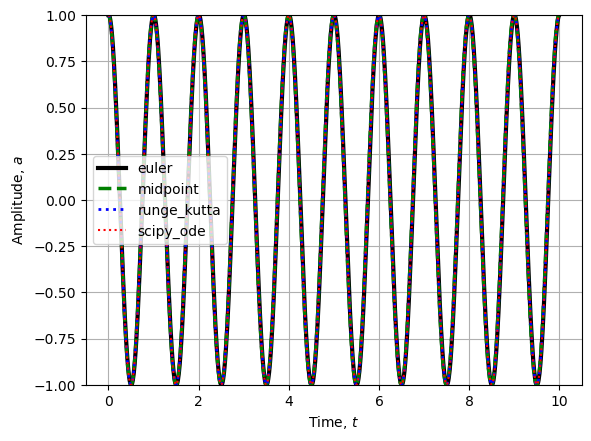

In [5]:
# Exercise 1 - simple harmonic oscillator
fig1 = main(zeta = 0.0, omega0 = 2.*np.pi, Fm = 0.0, omegad = 2.*np.pi, xInit0 = [1., 0.])

[1.0, 0.0]


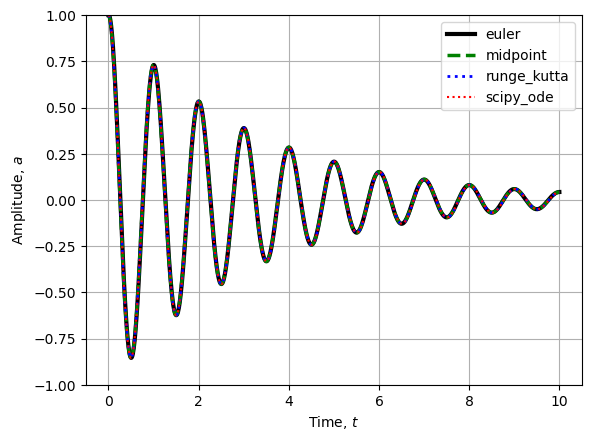

In [6]:
# Exercise 2 - damped harmonic oscillator - underdamped
fig2 = main(zeta = 0.05, omega0 = 2.*np.pi, Fm = 0.0, omegad = 2.*np.pi, xInit0 = [1., 0.])

[1.0, 0.0]


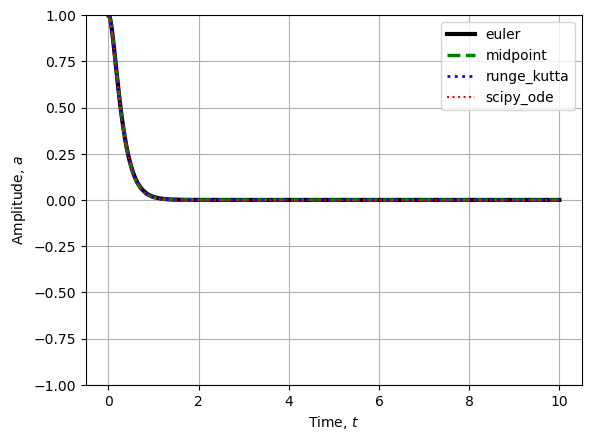

In [7]:
# Exercise 3 - damped harmonic oscillator - criticallly damped 
fig3 = main(zeta = 1., omega0 = 2.*np.pi, Fm = 0.0, omegad = 2.*np.pi, xInit0 = [1., 0.])

[1.0, 0.0]


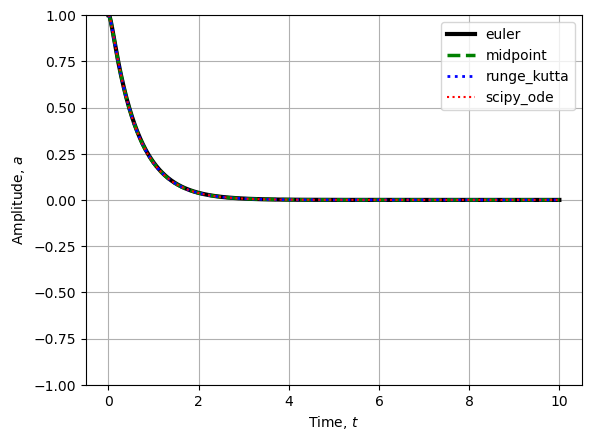

In [8]:
# Exercise 4 - damped harmonic oscillator - overdamped
fig4 = main(zeta = 2., omega0 = 2.*np.pi, Fm = 0.0, omegad = 2.*np.pi, xInit0 = [1., 0.])

[0.0, 0.0]


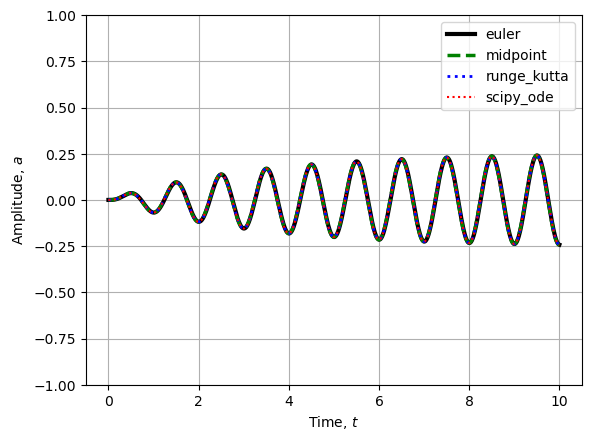

In [9]:
# Exercise 5 - driven harmonic oscillator
fig5 = main(zeta = 0.05, omega0 = 2.*np.pi, Fm = 1.0, omegad = 2.*np.pi, xInit0 = [0., 0.])

To disable auto-scrolling of the results, click the left bar of the figure cell or right-click the figure cell to choose 'disable auto-scrolling outputs'.

In [10]:
w = interactive(main, 
                zeta   = (0., 1., 0.01), 
                omega0 = (2.*np.pi*0.05, 2.*np.pi*5., 2.*np.pi*0.01),
                Fm     = fixed(1.),
                omegad = fixed(2.*np.pi),
                xInit0 = fixed([0.,0.]))
display(w)

interactive(children=(FloatSlider(value=0.05, description='zeta', max=1.0, step=0.01), FloatSlider(value=6.283…